# DPU example: MNIST Classifier
----

## 0. Import needed libraries

In [28]:
from pynq_dpu import DpuOverlay
from time import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import dsntnn
import torch
import onnxruntime as ort
import onnx
import onnxruntime.quantization as quantization

import os
os.environ["OPENCV_LOG_LEVEL"]="SILENT"
from pynq.lib.video import *

%matplotlib inline

In [37]:
#intialize displlay port
displayport = DisplayPort()
print(displayport.modes)
displayport.configure(VideoMode(640, 480, 24), PIXEL_RGB) 

capture = cv2.VideoCapture(0)
capture.isOpened()

capture.set(3, 640);
capture.set(4, 480)

[VideoMode: width=1920 height=1080 bpp=24 fps=60, VideoMode: width=1600 height=900 bpp=24 fps=60, VideoMode: width=1280 height=1024 bpp=24 fps=75, VideoMode: width=1280 height=1024 bpp=24 fps=60, VideoMode: width=1152 height=864 bpp=24 fps=75, VideoMode: width=1280 height=720 bpp=24 fps=60, VideoMode: width=1024 height=768 bpp=24 fps=75, VideoMode: width=1024 height=768 bpp=24 fps=60, VideoMode: width=800 height=600 bpp=24 fps=75, VideoMode: width=800 height=600 bpp=24 fps=60, VideoMode: width=640 height=480 bpp=24 fps=75, VideoMode: width=640 height=480 bpp=24 fps=60, VideoMode: width=720 height=400 bpp=24 fps=70]


True

## 1. Prepare the overlay

In [31]:
'''
Download the DPU overlay onto the board.
'''
overlay = DpuOverlay("dpu.bit")

The `load_model()` method will automatically prepare the `graph`
which is used by VART.

In [32]:
'''
- Here we only load the feature generator and compression layers into the DPU.
- Subsequent upsampling convolutional layers do not pass verification, so we move
  those to post-processing on the CPU.
- This hurts framerate, but gurantees correctness.
'''
overlay.load_model("backbone.xmodel")

## 2. Load test data

In [33]:
'''
- Image pre-processing function to prepare input data such 
  that it matches what was used during training.
'''
def rescale(image, output_size):
    image_ = image/256.0
    h, w = image_.shape[:2]
    im_scale = min(float(output_size[0]) / float(h), float(output_size[1]) / float(w))
    new_h = int(image_.shape[0] * im_scale)
    new_w = int(image_.shape[1] * im_scale)
    image = cv2.resize(image_, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    left_pad = (output_size[1] - new_w) // 2
    right_pad = (output_size[1] - new_w) - left_pad
    top_pad = (output_size[0] - new_h) // 2
    bottom_pad = (output_size[0] - new_h) - top_pad
    mean=np.array([0.485, 0.456, 0.406])
    pad = ((top_pad, bottom_pad), (left_pad, right_pad))
    image = np.stack([np.pad(image[:,:,c], pad, mode='constant', constant_values=mean[c])for c in range(3)], axis=2)
    pose_fun = lambda x: ((((x.reshape([-1,2])+np.array([1.0,1.0]))/2.0*np.array(output_size)-[left_pad, top_pad]) * 1.0 /np.array([new_w, new_h])*np.array([w,h])))
    return {'image': image, 'pose_fun': pose_fun}

'''
- Helper function to draw the pose wireframe onto the input image. Code from https://github.com/YuliangXiu/MobilePose.
'''
def draw_humans(npimg, pose, imgcopy=False):
    if imgcopy:
        npimg = np.copy(npimg)
    image_h, image_w = npimg.shape[:2]
    centers = {}

    colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0],
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255],
          [170, 0, 255], [255, 0, 255]]

    pairs = [[8,9],[11,12],[11,10],[2,1],[1,0],[13,14],[14,15],[3,4],[4,5],[8,7],[7,6],[6,2],[6,3],[8,12],[8,13]]
    colors_skeleton = ['r', 'y', 'y', 'g', 'g', 'y', 'y', 'g', 'g', 'm', 'm', 'g', 'g', 'y','y']
    colors_skeleton = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0],
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255],
          [170, 0, 255]]

    for idx in range(len(colors)):
        cv2.circle(npimg, (pose[idx,0], pose[idx,1]), 3, colors[idx], thickness=3, lineType=8, shift=0)
    for idx in range(len(colors_skeleton)):
        npimg = cv2.line(npimg, (pose[pairs[idx][0],0], pose[pairs[idx][0],1]), (pose[pairs[idx][1],0], pose[pairs[idx][1],1]), colors_skeleton[idx], 3)

    return npimg

'''
- Helper function to crop camera inputs to a specified ratio. Code from https://github.com/YuliangXiu/MobilePose.
'''
def crop_camera(image, ratio=0.15):
    height = image.shape[0]
    width = image.shape[1]
    mid_width = width / 2.0
    width_20 = width * ratio
    crop_img = image[0:int(height), int(mid_width - width_20):int(mid_width + width_20)]
    return crop_img

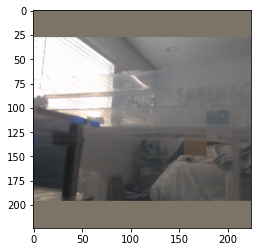

In [40]:
# Load the input image
val, test_img = capture.read()

# Convert to the expected RGB format
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Apply the rescale transform
rescale_out = rescale(test_img, (224, 224))

# Show the image
plt.imshow(rescale_out['image'])
plt.show()

## 3. Use VART
Now we should be able to use VART API to do the task.

In [41]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])


print(f"Input Shape  : {shapeIn}")
print(f"Output Shape : {shapeOut}")

Input Shape  : (1, 224, 224, 3)
Output Shape : (1, 7, 7, 256)


We can define a few buffers to store input and output data.
They will be reused during multiple runs.

In [42]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]

## 4. CPU (ONNX/FP32)

In [43]:
trials = 500

ort_provider = ['CPUExecutionProvider']
ort_sess = ort.InferenceSession('mobile_pose.onnx', providers=ort_provider)

start = time()
for _ in range(trials):
    # Pre-processing
    val, test_img = capture.read()
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) #Conver to expected format
   # test_img = cv2.imread('./test.jpg')
   # test_img = crop_camera(test_img)
    rescale_out = rescale(test_img, (224, 224))
    rescaled_input = rescale_out['image'].astype(np.float32)
    rescaled_input = np.swapaxes(rescaled_input, 0, 2)
    rescaled_input = np.swapaxes(rescaled_input, 1, 2)
    rescaled_input = np.expand_dims(rescaled_input, axis=0)

    ort_inputs = {ort_sess.get_inputs()[0].name: rescaled_input}
    coords = ort_sess.run(None, ort_inputs)[0]
    coords = rescale_out['pose_fun'](coords).astype(int)
    
    #Display Output to monitor 
    res = draw_humans(test_img, coords)
    res = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
    #cv2.imwrite('inference_test.jpg', res)
    frame = displayport.newframe()
    frame[:] = res;
    displayport.writeframe(frame)

stop = time()


execution_time = stop - start
print("Execution time: {:.4f}s".format(execution_time))
print("Throughput: {:.4f}FPS".format(trials/execution_time))

Execution time: 15.9323s
Throughput: 3.1383FPS


## 5. CPU (ONNX/INT8)

In [45]:
trials = 500

ort_provider = ['CPUExecutionProvider']
ort_sess = ort.InferenceSession('mobile_pose_quant.onnx', providers=ort_provider)

start = time()
for _ in range(trials):
    # Pre-processing
    # Pre-processing
    val, test_img = capture.read()
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) #Conver to expected format
   # test_img = cv2.imread('./test.jpg')
   # test_img = crop_camera(test_img)
    rescale_out = rescale(test_img, (224, 224))
    rescaled_input = rescale_out['image'].astype(np.float32)
    rescaled_input = np.swapaxes(rescaled_input, 0, 2)
    rescaled_input = np.swapaxes(rescaled_input, 1, 2)
    rescaled_input = np.expand_dims(rescaled_input, axis=0)

    ort_inputs = {ort_sess.get_inputs()[0].name: rescaled_input}
    coords = ort_sess.run(None, ort_inputs)[0]
    coords = rescale_out['pose_fun'](coords).astype(int)
    
     #Display Output to monitor 
    res = draw_humans(test_img, coords)
    res = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
   # cv2.imwrite('inference_test.jpg', res)
    frame = displayport.newframe()
    frame[:] = res;
    displayport.writeframe(frame)

stop = time()

execution_time = stop - start
print("Execution time: {:.4f}s".format(execution_time))
print("Throughput: {:.4f}FPS".format(trials/execution_time))

Execution time: 6.7159s
Throughput: 7.4450FPS


## 6. DPU + CPU (ONNX/FP32)

In [46]:
trials = 500

ort_provider = ['CPUExecutionProvider']
ort_sess = ort.InferenceSession('post_proc.onnx', providers=ort_provider)

start = time()
for _ in range(trials):
    # Pre-processing
    val, test_img = capture.read()
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) #Conver to expected forma
    rescale_out = rescale(test_img, (224, 224))
    rescaled_input = rescale_out['image']
    
    # Execute DPU inference
    image[0,...] = rescaled_input
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    
    # Extract the output from the DPU buffer and reshape it for further processing
    x = np.array(output_data)[0]
    x = np.swapaxes(x, 1, 3)
    x = np.swapaxes(x, 2, 3)

    # Post-processing
    x = {ort_sess.get_inputs()[0].name: x}
    coords = ort_sess.run(None, x)[0]
    coords = rescale_out['pose_fun'](coords).astype(int)
    
    #Display Output to monitor 
    res = draw_humans(test_img, coords)
    res = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
    frame = displayport.newframe()
    frame[:] = res;
    displayport.writeframe(frame)
stop = time()

# # Display results
res = draw_humans(test_img, coords)
cv2.imwrite('inference_test.jpg', res)

execution_time = stop - start
print("Execution time: {:.4f}s".format(execution_time))
print("Throughput: {:.4f}FPS".format(trials/execution_time))

Execution time: 5.1418s
Throughput: 9.7242FPS


## 5. Pure CPU Test Using a Quantized ONNX Model

In [48]:
trials = 1000

ort_provider = ['CPUExecutionProvider']
ort_sess = ort.InferenceSession('post_proc_quant.onnx', providers=ort_provider)

start = time()
for _ in range(trials):
    # Pre-processing
    val, test_img = capture.read()
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) #Conver to expected forma
    rescale_out = rescale(test_img, (224, 224))
    rescaled_input = rescale_out['image']
    
    # Execute DPU inference
    image[0,...] = rescaled_input
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    
    # Extract the output from the DPU buffer and reshape it for further processing
    x = np.array(output_data)[0]
    x = np.swapaxes(x, 1, 3)
    x = np.swapaxes(x, 2, 3)

    # Post-processing
    x = {ort_sess.get_inputs()[0].name: x}
    coords = ort_sess.run(None, x)[0]
    coords = rescale_out['pose_fun'](coords).astype(int)
    
    #Display Output to monitor 
    res = draw_humans(test_img, coords)
    res = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
    frame = displayport.newframe()
    frame[:] = res;
    displayport.writeframe(frame)
stop = time()


execution_time = stop - start
print("Execution time: {:.4f}s".format(execution_time))
print("Throughput: {:.4f}FPS".format(trials/execution_time))

Execution time: 4.3008s
Throughput: 11.6259FPS


## 6. Clean up

We will need to remove references to `vart.Runner` and let Python garbage-collect
the unused graph objects. This will make sure we can run other notebooks without
any issue.

In [12]:
del overlay
del dpu